# Simple Linear Regression With OLS

In [1]:
import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load the dataset and inspect it's contents.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Missing Values
### Variable types
Create lists of continuous and categorical data.

In [7]:
cont_variables, cat_variables = hp.find_variable_types(df)

In [8]:
print(f'Continuous variables:\n{cont_variables}\n')
print(f'Categorical variables:\n{cat_variables}')

Continuous variables:
['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']

Categorical variables:
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'function

Remove `'id'` column from `cont_variables` since this column isn't a variable.

In [9]:
cont_variables.remove('id')

In [10]:
print(cont_variables)

['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']


### Year variables
Convert year variables into durations (ages).

In [11]:
year_columns = ['garageyrblt', 'yearremodadd', 'yearbuilt', 'yrsold']
age_columns = ['garageage', 'remodage', 'age', 'yrsoffmk']

In [12]:
df_clean = df.copy()

In [13]:
df_clean['garageyrblt'].fillna(value=2019, inplace=True)
df_clean = df_clean.astype({'garageyrblt': 'int64'})

In [14]:
for i, year_type in enumerate(year_columns):
    
    df_clean[age_columns[i]] = 2019 - df_clean[year_type]

In [15]:
df_clean.loc[:, age_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
garageage    1460 non-null int64
remodage     1460 non-null int64
age          1460 non-null int64
yrsoffmk     1460 non-null int64
dtypes: int64(4)
memory usage: 45.7 KB


In [16]:
df_clean.loc[:, age_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
garageage,1460.0,38.247260,25.724002,0.0,16.0,34.5,57.0,119.0
remodage,1460.0,34.134247,20.645407,9.0,15.0,25.0,52.0,69.0
age,1460.0,47.732192,30.202904,9.0,19.0,46.0,65.0,147.0
yrsoffmk,1460.0,11.184247,1.328095,9.0,10.0,11.0,12.0,13.0


Drop year columns, keeping only the age columns.

In [17]:
df_clean.drop(year_columns, axis=1, inplace=True)

Update continuous variables list.

In [18]:
cont_variables = [x for x in cont_variables if x not in year_columns]
cont_variables += age_columns

### Unique categories
Print unique categories.

In [19]:
hp.print_unique_categories(df, cat_variables)

mszoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
street: ['Pave' 'Grvl']
alley: [None 'Grvl' 'Pave']
lotshape: ['Reg' 'IR1' 'IR2' 'IR3']
landcontour: ['Lvl' 'Bnk' 'Low' 'HLS']
utilities: ['AllPub' 'NoSeWa']
lotconfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
landslope: ['Gtl' 'Mod' 'Sev']
neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
bldgtype: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
housestyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
roofstyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
roofmatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
exterior1st: ['V

### Missing categories
The missing category columns are labeled at `None`. I will replace these with `"None"`.

In [20]:
df_clean = hp.fill_missing_categories(df_clean, cat_variables)

In [21]:
df_clean.loc[:, cat_variables].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
mszoning         1460 non-null object
street           1460 non-null object
alley            1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1460 non-null object
exterqual        1460 non-null object
extercond        1460 non-null object
foundation       1460 non-null object
bsmtqual         1460 non-null object
bsmtcond         1460 non-null object
bsmtexposure     14

### Missing value fractions

In [22]:
hp.find_na_columns(df_clean, display_fractions=True)

lotfrontage    17.739726
masvnrarea      0.547945
dtype: float64


In [23]:
na_fractions = hp.find_na_columns(df_clean)

In [24]:
df_clean.loc[:, na_fractions.index].describe().T

,count,mean,std,min,25%,50%,75%,max
lotfrontage,1201.0,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
masvnrarea,1452.0,103.685262,181.066207,0.0,0.0,0.0,166.0,1600.0


Handling each case separately.

#### `'lotfrontage'`
* Fill missing values with zeros.

In [25]:
df_clean['lotfrontage'].fillna(value=0, inplace=True)

#### `'masvnarea'`
* Fill missing values with zeros.

In [26]:
df_clean['masvnrarea'].fillna(value=0, inplace=True)

In [27]:
hp.find_na_columns(df_clean, display_fractions=True)

Series([], dtype: float64)


All missing values have now been dealt with.

In [28]:
print(f'The dataset size is still {len(df_clean)}.')

The dataset size is still 1460.


In [29]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
mssubclass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
lotfrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
lotarea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
overallqual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
overallcond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
masvnrarea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
bsmtfinsf1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
bsmtfinsf2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
bsmtunfsf,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


### Standardize
Standarize all continous variables.

In [30]:
cont_variables

['mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 'threessnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'saleprice',
 'garageage',
 'remodage',
 'age',
 'yrsoffmk']

In [31]:
stand_variables = [f'{x}_sd' for x in cont_variables]
df_clean = hp.standardize(df_clean, cont_variables)

### Feature Selection
#### Continous Variables
Select variables that are correlated with saleprice.

In [32]:
df_correlated = df_clean.loc[:, stand_variables].corr()
correlated_with_saleprice = df_correlated['saleprice_sd'].sort_values()

In [33]:
correlated_with_saleprice

age_sd             -0.522897
remodage_sd        -0.507101
garageage_sd       -0.353196
kitchenabvgr_sd    -0.135907
enclosedporch_sd   -0.128578
mssubclass_sd      -0.084284
overallcond_sd     -0.077856
lowqualfinsf_sd    -0.025606
miscval_sd         -0.021190
bsmthalfbath_sd    -0.016844
bsmtfinsf2_sd      -0.011378
yrsoffmk_sd         0.028923
threessnporch_sd    0.044584
mosold_sd           0.046432
poolarea_sd         0.092404
screenporch_sd      0.111447
bedroomabvgr_sd     0.168213
lotfrontage_sd      0.209624
bsmtunfsf_sd        0.214479
bsmtfullbath_sd     0.227122
lotarea_sd          0.263843
halfbath_sd         0.284108
openporchsf_sd      0.315856
secondflrsf_sd      0.319334
wooddecksf_sd       0.324413
bsmtfinsf1_sd       0.386420
fireplaces_sd       0.466929
masvnrarea_sd       0.472614
totrmsabvgrd_sd     0.533723
fullbath_sd         0.560664
firstflrsf_sd       0.605852
totalbsmtsf_sd      0.613581
garagearea_sd       0.623431
garagecars_sd       0.640409
grlivarea_sd  

In [34]:
correlated_features = correlated_with_saleprice[correlated_with_saleprice > 0.6].index.tolist()
correlated_features.remove('saleprice_sd')

In [35]:
print(f'Features that have at least a 0.6 correlations with sale price are:\n{correlated_features}')

Features that have at least a 0.6 correlations with sale price are:
['firstflrsf_sd', 'totalbsmtsf_sd', 'garagearea_sd', 'garagecars_sd', 'grlivarea_sd', 'overallqual_sd']


Create list of continous variables that includes the selected continous variable features as well as `'saleprice_sd'`.

In [36]:
correlated_variables = correlated_features
correlated_variables.append('saleprice_sd')

In [37]:
df_clean.loc[:, correlated_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
firstflrsf_sd,1460.0,6.205082e-17,1.0,-2.143438,-0.725907,-0.195626,0.591388,9.129553
totalbsmtsf_sd,1460.0,2.555034e-16,1.0,-2.410341,-0.596481,-0.150282,0.548935,11.517003
garagearea_sd,1460.0,-9.733462e-18,1.0,-2.212205,-0.647694,0.032833,0.481841,4.420012
garagecars_sd,1460.0,5.353404e-17,1.0,-2.364630,-1.026506,0.311618,0.311618,2.987865
grlivarea_sd,1460.0,-1.411352e-16,1.0,-2.248350,-0.734497,-0.097936,0.497233,7.852884
overallqual_sd,1460.0,1.143682e-16,1.0,-3.687150,-0.794879,-0.071812,0.651256,2.820459
saleprice_sd,1460.0,1.387018e-16,1.0,-1.838074,-0.641296,-0.225587,0.416387,7.226343


#### Catagorical variables
Use chi-squared technique to remove categorical variables that are not correlated with `'saleprice'`.

In [38]:
cat_features = hp.select_cat_variables(df_clean, 'saleprice', cat_variables, alpha=0.05)

Chi-squared Statistics:
* mszoning: chi2 = 3147.891, p-value = 4.348e-11, dof = 2648
* street: chi2 = 888.313, p-value = 8.339e-09, dof = 662
* lotshape: chi2 = 2446.235, p-value = 4.725e-12, dof = 1986
* lotconfig: chi2 = 2771.985, p-value = 4.581e-02, dof = 2648
* neighborhood: chi2 = 16898.756, p-value = 1.365e-08, dof = 15888
* masvnrtype: chi2 = 2293.470, p-value = 1.598e-06, dof = 1986
* exterqual: chi2 = 2849.767, p-value = 4.250e-34, dof = 1986
* extercond: chi2 = 3192.840, p-value = 9.870e-13, dof = 2648
* foundation: chi2 = 3669.192, p-value = 9.665e-06, dof = 3310
* bsmtqual: chi2 = 3552.151, p-value = 1.192e-29, dof = 2648
* bsmtcond: chi2 = 3386.500, p-value = 4.710e-21, dof = 2648
* bsmtexposure: chi2 = 3230.188, p-value = 3.496e-14, dof = 2648
* heating: chi2 = 4201.388, p-value = 2.478e-24, dof = 3310
* centralair: chi2 = 826.857, p-value = 1.226e-05, dof = 662
* kitchenqual: chi2 = 2811.800, p-value = 1.282e-31, dof = 1986
* fireplacequ: chi2 = 3763.900, p-value = 4.38

In [39]:
cat_features

['mszoning',
 'street',
 'lotshape',
 'lotconfig',
 'neighborhood',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'heating',
 'centralair',
 'kitchenqual',
 'fireplacequ',
 'garagefinish',
 'saletype',
 'salecondition']

In [40]:
hp.print_unique_categories(df_clean, cat_features)

mszoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
street: ['Pave' 'Grvl']
lotshape: ['Reg' 'IR1' 'IR2' 'IR3']
lotconfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
masvnrtype: ['BrkFace' 'None' 'Stone' 'BrkCmn']
exterqual: ['Gd' 'TA' 'Ex' 'Fa']
extercond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
foundation: ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
bsmtqual: ['Gd' 'TA' 'Ex' 'None' 'Fa']
bsmtcond: ['TA' 'Gd' 'None' 'Fa' 'Po']
bsmtexposure: ['No' 'Gd' 'Mn' 'Av' 'None']
heating: ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
centralair: ['Y' 'N']
kitchenqual: ['Gd' 'TA' 'Ex' 'Fa']
fireplacequ: ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish: ['RFn' 'Unf' 'Fin' 'None']
saletype: ['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
salecondition

Convert categorical features into dummy, one-hot-encoded variables.

In [41]:
df_clean = hp.dummyify(df_clean, cat_features)

#### Correlated categorical features
Inspect correlated dummy features and remove them.

In [42]:
dummy_features = [x for x in df_clean.columns.tolist() if x[-3:] == '_oh']
df_cat_correalated = df_clean.loc[:, dummy_features].corr().copy()

In [43]:
df_cat_correalated[df_cat_correalated < -0.8].dropna(how='all').dropna(how='all', axis=1)

,mszoning_RL_oh,mszoning_RM_oh,masvnrtype_BrkFace_oh,masvnrtype_None_oh,exterqual_Gd_oh,exterqual_TA_oh,extercond_Gd_oh,extercond_TA_oh,kitchenqual_Gd_oh,kitchenqual_TA_oh
mszoning_RL_oh,NaN,-0.808585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mszoning_RM_oh,-0.808585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
masvnrtype_BrkFace_oh,NaN,NaN,NaN,-0.806337,NaN,NaN,NaN,NaN,NaN,NaN
masvnrtype_None_oh,NaN,NaN,-0.806337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exterqual_Gd_oh,NaN,NaN,NaN,NaN,NaN,-0.906121,NaN,NaN,NaN,NaN
exterqual_TA_oh,NaN,NaN,NaN,NaN,-0.906121,NaN,NaN,NaN,NaN,NaN
extercond_Gd_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.894567,NaN,NaN
extercond_TA_oh,NaN,NaN,NaN,NaN,NaN,NaN,-0.894567,NaN,NaN,NaN
kitchenqual_Gd_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.824457
kitchenqual_TA_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.824457,NaN


In [44]:
df_positive_corr_cats = df_cat_correalated[df_cat_correalated < -0.8].dropna(how='all').dropna(how='all',
                                                                                               axis=1).copy()

In [45]:
df_cat_correalated[(df_cat_correalated > 0.8) & (df_cat_correalated < 1.0)].dropna(how='all').dropna(how='all', axis=1)

,mszoning_FV_oh,neighborhood_Somerst_oh,foundation_Slab_oh,bsmtqual_None_oh,bsmtcond_None_oh,bsmtexposure_None_oh,saletype_New_oh,salecondition_Partial_oh
mszoning_FV_oh,NaN,0.862807,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Somerst_oh,0.862807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
foundation_Slab_oh,NaN,NaN,NaN,0.801733,0.801733,NaN,NaN,NaN
bsmtqual_None_oh,NaN,NaN,0.801733,NaN,NaN,0.986408,NaN,NaN
bsmtcond_None_oh,NaN,NaN,0.801733,NaN,NaN,0.986408,NaN,NaN
bsmtexposure_None_oh,NaN,NaN,NaN,0.986408,0.986408,NaN,NaN,NaN
saletype_New_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986819
salecondition_Partial_oh,NaN,NaN,NaN,NaN,NaN,NaN,0.986819,NaN


In [46]:
df_negative_corr_cats = df_cat_correalated[(df_cat_correalated > 0.8) & 
                                       (df_cat_correalated < 1.0)].dropna(how='all').dropna(how='all', 
                                                                                            axis=1).copy()

In [47]:
correlated_cats = df_positive_corr_cats.columns.tolist() + df_negative_corr_cats.columns.tolist()
dummy_features = [x for x in dummy_features if x not in correlated_cats]

### Normality
Check standardized continous variable for normality. Correct normality using Box-Cox transformation.

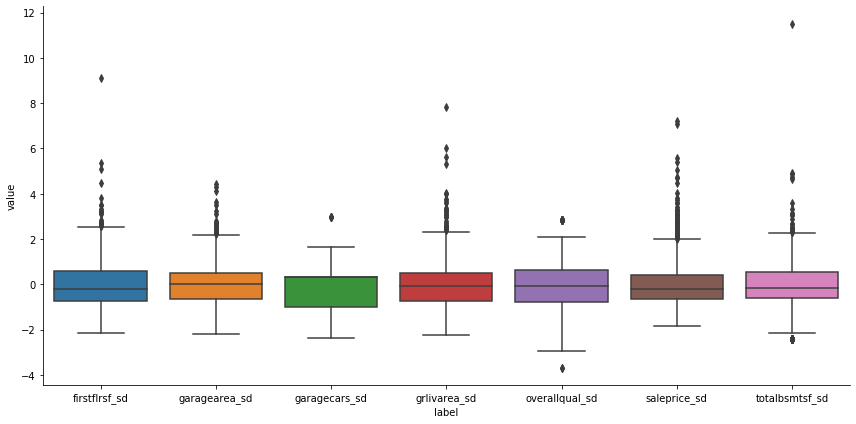

In [48]:
hp.look_for_outliers(df_clean, correlated_variables)

In [49]:
hp.check_for_normality(df_clean, correlated_variables)

Normal test results:
* firstflrsf_sd: normal_stat = 461.007, p-value = 0.0000.
* totalbsmtsf_sd: normal_stat = 622.895, p-value = 0.0000.
* garagearea_sd: normal_stat = 34.041, p-value = 0.0000.
* garagecars_sd: normal_stat = 29.925, p-value = 0.0000.
* grlivarea_sd: normal_stat = 437.120, p-value = 0.0000.
* overallqual_sd: normal_stat = 11.905, p-value = 0.0026.
* saleprice_sd: normal_stat = 610.836, p-value = 0.0000.


**Observation:** All continous variables are not normal.

In [50]:
bc_variables = [f'{x}_bc' for x in correlated_variables]
df_clean = hp.apply_boxcox_transform(df_clean, correlated_variables)

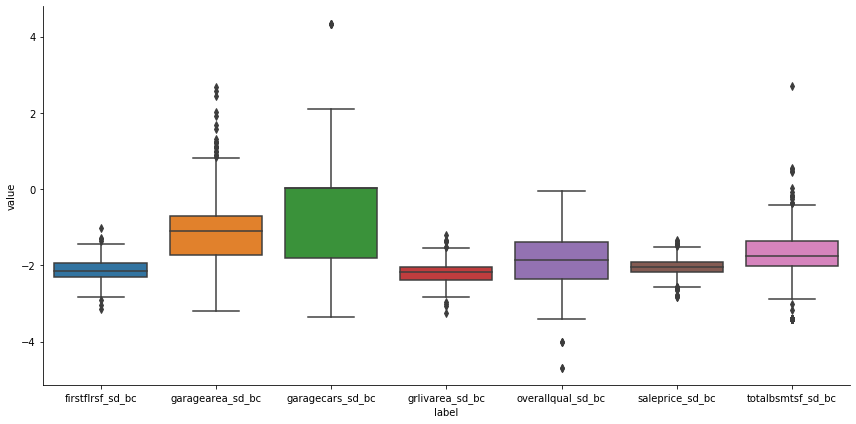

In [51]:
hp.look_for_outliers(df_clean, bc_variables)

In [52]:
hp.check_for_normality(df_clean, bc_variables)

Normal test results:
* firstflrsf_sd_bc: normal_stat = 0.702, p-value = 0.7039.
* totalbsmtsf_sd_bc: normal_stat = 145.808, p-value = 0.0000.
* garagearea_sd_bc: normal_stat = 24.068, p-value = 0.0000.
* garagecars_sd_bc: normal_stat = 1.357, p-value = 0.5073.
* grlivarea_sd_bc: normal_stat = 1.865, p-value = 0.3935.
* overallqual_sd_bc: normal_stat = 3.444, p-value = 0.1787.
* saleprice_sd_bc: normal_stat = 13.180, p-value = 0.0014.


**Observations:** Now only three continous variables are not normal: `'totalbsmtsf_sd_bc'`, `'garagearea_sd_bc'`, `'saleprice_sd_bc'`. The outlier haven't been removed. I will remove them and see if that helps.

### Outliers

In [53]:
# Correct outliers using Tukey method
tk_corrected = [f'{x}_tk' for x in bc_variables]
df_clean = hp.correct_outliers(df_clean, bc_variables)

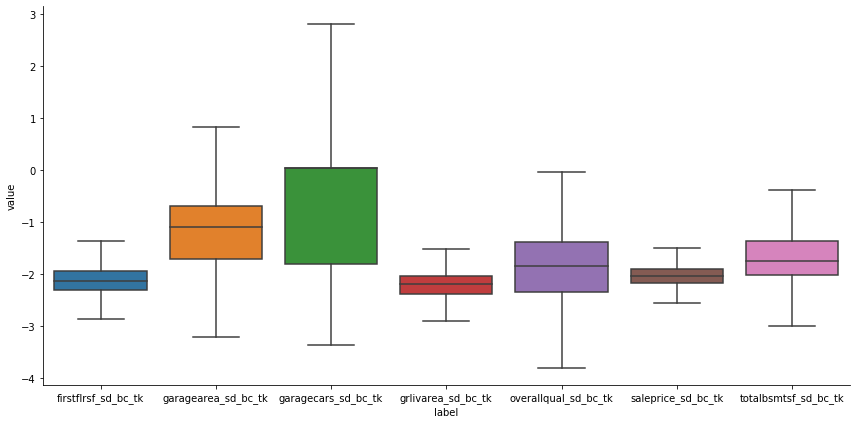

In [54]:
hp.look_for_outliers(df_clean, tk_corrected)

Check for normality again.

In [55]:
hp.check_for_normality(df_clean, tk_corrected)

Normal test results:
* firstflrsf_sd_bc_tk: normal_stat = 3.188, p-value = 0.2032.
* totalbsmtsf_sd_bc_tk: normal_stat = 4.687, p-value = 0.0960.
* garagearea_sd_bc_tk: normal_stat = 9.270, p-value = 0.0097.
* garagecars_sd_bc_tk: normal_stat = 4.061, p-value = 0.1312.
* grlivarea_sd_bc_tk: normal_stat = 5.014, p-value = 0.0815.
* overallqual_sd_bc_tk: normal_stat = 3.420, p-value = 0.1808.
* saleprice_sd_bc_tk: normal_stat = 1.433, p-value = 0.4884.


**Observations:** Now only `'garagearea_sd_bc_tk'` is not normal.

## Data Exploration
Collect categorical features and contious variables.

In [56]:
cont_corrected_features = ['firstflrsf_sd_bc_tk', 'totalbsmtsf_sd_bc_tk', 'garagearea_sd_bc_tk', 
                           'garagecars_sd_bc_tk', 'grlivarea_sd_bc_tk', 'overallqual_sd_bc_tk']

In [57]:
df_clean.loc[:, cont_corrected_features].corr()

,firstflrsf_sd_bc_tk,totalbsmtsf_sd_bc_tk,garagearea_sd_bc_tk,garagecars_sd_bc_tk,grlivarea_sd_bc_tk,overallqual_sd_bc_tk
firstflrsf_sd_bc_tk,1.000000,0.789215,0.479357,0.457413,0.535177,0.444495
totalbsmtsf_sd_bc_tk,0.789215,1.000000,0.479922,0.466705,0.416480,0.530761
garagearea_sd_bc_tk,0.479357,0.479922,1.000000,0.893855,0.474322,0.562538
garagecars_sd_bc_tk,0.457413,0.466705,0.893855,1.000000,0.506500,0.611141
grlivarea_sd_bc_tk,0.535177,0.416480,0.474322,0.506500,1.000000,0.608304
overallqual_sd_bc_tk,0.444495,0.530761,0.562538,0.611141,0.608304,1.000000


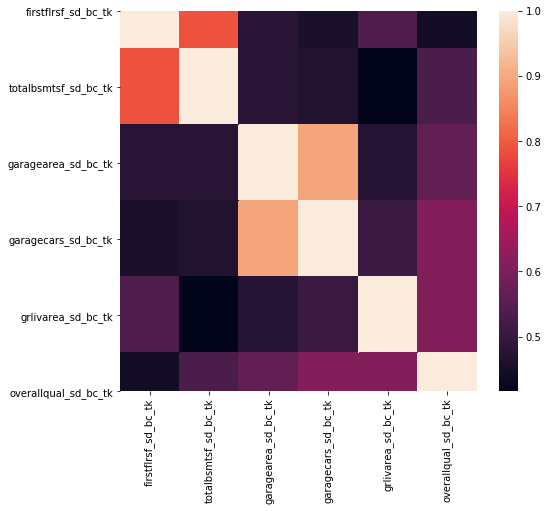

In [58]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_clean.loc[:, cont_corrected_features].corr(), ax=axes)
plt.show()

**Observations:** `'garagearea_sd_bc_tk'` and `'garagecars_sd_bc_tk'` have a high correlation. I will create a new variable, `'garage_car_area'` by multiplying these two variables.

In [59]:
df_clean['garage_car_area'] = df_clean['garagearea_sd_bc_tk']*df_clean['garagecars_sd_bc_tk']

In [60]:
# Add the new feature
cont_corrected_features.append('garage_car_area')

# # Drop garagearea_sd_bc_tk and garagecars_sd_bc_tk
cont_corrected_features.remove('garagearea_sd_bc_tk')
cont_corrected_features.remove('garagecars_sd_bc_tk')

In [61]:
df_clean.loc[:, cont_corrected_features].corr()

,firstflrsf_sd_bc_tk,totalbsmtsf_sd_bc_tk,grlivarea_sd_bc_tk,overallqual_sd_bc_tk,garage_car_area
firstflrsf_sd_bc_tk,1.000000,0.789215,0.535177,0.444495,-0.301979
totalbsmtsf_sd_bc_tk,0.789215,1.000000,0.416480,0.530761,-0.279925
grlivarea_sd_bc_tk,0.535177,0.416480,1.000000,0.608304,-0.341120
overallqual_sd_bc_tk,0.444495,0.530761,0.608304,1.000000,-0.417907
garage_car_area,-0.301979,-0.279925,-0.341120,-0.417907,1.000000


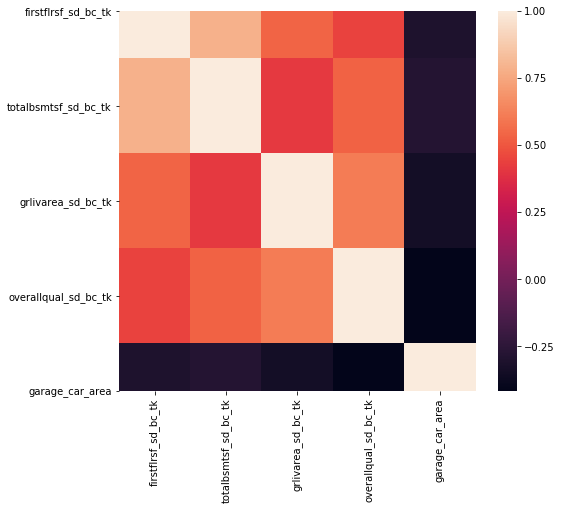

In [62]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_clean.loc[:, cont_corrected_features].corr(), ax=axes)
plt.show()

## Model
Now that I have selected the best features, I will create a linear regression model using Scikit-Learn.

In [63]:
all_features = dummy_features + cont_corrected_features
df_model_features = df_clean.loc[:, all_features].copy()
df_model = df_clean.loc[:, all_features + ['saleprice_sd_bc_tk']].copy()

In [64]:
X = df_model.loc[:, all_features]
y = df_model['saleprice_sd_bc_tk']

lrm = linear_model.LinearRegression()

lrm.fit(X, y)

print(f'Coefficients: {lrm.coef_}')
print(f'Intercept: {lrm.intercept_}')

Coefficients: [-0.00896926  0.0375263   0.02989304 -0.03631259 -0.00426042  0.01904487
 -0.02390866 -0.0279888  -0.00305205 -0.13793035 -0.14594395 -0.04689444
 -0.006472   -0.01195875  0.03522094 -0.08654385 -0.02875031 -0.10954214
 -0.15260512 -0.04746214 -0.05039418 -0.07810896 -0.03665632  0.04314475
  0.03461302 -0.09502197 -0.05383704 -0.04910695 -0.02221503  0.02777357
 -0.0060088   0.0205591   0.01340986 -0.01385042 -0.04179373 -0.17707022
  0.02006231  0.02616991  0.0438275  -0.01730083 -0.05126884 -0.03468624
 -0.04393062  0.06988064 -0.060113    0.0519118   0.02776413 -0.0055151
 -0.01945235  0.03413152  0.07576803  0.0040602  -0.00604595  0.04490775
  0.05979872 -0.01299435 -0.01479754 -0.02235261 -0.04156735 -0.03615536
 -0.02809284 -0.01422396 -0.00956244 -0.02612484 -0.00989877  0.02566863
 -0.00423056 -0.03650851 -0.02090187 -0.01030069 -0.02610248  0.02399444
  0.00760844 -0.02096014  0.03117512 -0.00931097  0.05617538  0.26927629
  0.06548743 -0.00518558]
Intercept: -

In [65]:
results_dict = {'features': all_features,
               'coefficients': lrm.coef_}
df_results = pd.DataFrame(results_dict)

In [66]:
df_results.describe().T

,count,mean,std,min,25%,50%,75%,max
coefficients,80.0,-0.011142,0.058788,-0.17707,-0.036362,-0.01113,0.024413,0.269276


**Observations:** The intercept is -1.3. The coefficients are between -0.17 and 0.27.

#### Save model dataset
Save the dataset use to create the housing price model to a .csv file.

In [67]:
df_model.to_csv('./housing_price_model.csv')